In [1]:
# import newsgroup dataset from sklearn datasets
from sklearn.datasets import fetch_20newsgroups

# select the categories of interest
categories = ['talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'alt.atheism', 'soc.religion.christian', 'sci.space', 'sci.med', 'talk.religion.misc']

# sample a training set
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True)

In [2]:
for i in range(len(categories)):
    print("i: " + str(i) + " " + twenty_train.target_names[i])

i: 0 alt.atheism
i: 1 sci.med
i: 2 sci.space
i: 3 soc.religion.christian
i: 4 talk.politics.guns
i: 5 talk.politics.mideast
i: 6 talk.politics.misc
i: 7 talk.religion.misc


In [3]:
# Feature Engineering:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts

<4218x56634 sparse matrix of type '<class 'numpy.int64'>'
	with 794945 stored elements in Compressed Sparse Row format>

In [4]:
import numpy as np
# We now apply the (Multinomial) Naive Bayes; 

# Remember the 5 steps we need to apply...

# 1. Select model and import it
from sklearn.naive_bayes import MultinomialNB

# 2. Select model hyperparameters; alpha is a smoothing parameter
model = MultinomialNB(alpha=10)

# 3. Arrange data in feature matrix / perform feature engineering
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
Y = twenty_train.target

# 4. Fit model to data
clf = model.fit(X_train_counts, Y)

# 5. Apply model to new examples
docs_new = ['God is love', 'blabla I don\'t belong to anything' ,'We will explore Mars','Human DNA for Genome', 'Israel and Palestine are at War', 'Authorize gun dealers']
X_new_counts = count_vect.transform(docs_new)

#Take in account probability as in the speeches, many sentences will not belong to any of the categories
predicted_proba = clf.predict_proba(X_new_counts)

for doc, probasArray in zip(docs_new, predicted_proba):
    indexMaxProbas = np.argmax(probasArray)
    print('%r => %s (Probability: %.2f)' % (doc, twenty_train.target_names[indexMaxProbas], probasArray[indexMaxProbas]))

'God is love' => soc.religion.christian (Probability: 0.83)
"blabla I don't belong to anything" => talk.politics.mideast (Probability: 0.22)
'We will explore Mars' => sci.space (Probability: 0.64)
'Human DNA for Genome' => sci.med (Probability: 0.45)
'Israel and Palestine are at War' => talk.politics.mideast (Probability: 1.00)
'Authorize gun dealers' => talk.politics.guns (Probability: 0.91)


In [5]:
"""
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from pprint import pprint
from sklearn.model_selection import GridSearchCV
import numpy as np
from time import time
import logging

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())])

parameters = {
    'vect__ngram_range': ((1, 1), (1, 2), (1,3), (1,4)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'clf__alpha': (0.1, 0.01, 0.001, 0.0001, 1),
}

if __name__ == "__main__":
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    grid_search.fit(twenty_train.data, twenty_train.target)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
"""

'\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.feature_extraction.text import TfidfTransformer\nfrom pprint import pprint\nfrom sklearn.model_selection import GridSearchCV\nimport numpy as np\nfrom time import time\nimport logging\n\npipeline = Pipeline([\n    (\'vect\', CountVectorizer()),\n    (\'tfidf\', TfidfTransformer()),\n    (\'clf\', MultinomialNB())])\n\nparameters = {\n    \'vect__ngram_range\': ((1, 1), (1, 2), (1,3), (1,4)),  # unigrams or bigrams\n    \'tfidf__use_idf\': (True, False),\n    \'clf__alpha\': (0.1, 0.01, 0.001, 0.0001, 1),\n}\n\nif __name__ == "__main__":\n    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)\n\n    print("Performing grid search...")\n    print("pipeline:", [name for name, _ in pipeline.steps])\n    print("parameters:")\n    print(parameters)\n    t0 = time()\n    grid_search.fit(twenty_train.data, twenty_train.target)\n    print("done in %0.3fs" % (time() - t0))\n    print()\n\n    print("Best score: %0.3f

In [6]:
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

text_clf = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', MultinomialNB(alpha=0.001))])

text_clf.fit(twenty_train.data, twenty_train.target)

# create a test set -> this is a set different than the train set
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)
docs_test = twenty_test.data
predicted_probas = text_clf.predict_proba(docs_test)

good_pred = np.array([])
good_target = np.array([])
for probasArray, target in zip(predicted_probas, twenty_test.target):
    indexMaxProbas = np.argmax(probasArray)
    if (probasArray[indexMaxProbas] > 0.70):
        good_pred = np.append(good_pred, indexMaxProbas)
        good_target = np.append(good_target, target)

good_pred =  good_pred.astype(int)
good_target =  good_target.astype(int)
matOptiFiltered = confusion_matrix(good_target, good_pred)

print(matOptiFiltered)
print(np.mean(good_target == good_pred))
predicted = text_clf.predict(docs_test)
matOptiNonFiltered = confusion_matrix(twenty_test.target, predicted)
print("\n \n ----------------------------- \n \n")
print(matOptiNonFiltered)
print(np.mean(predicted == twenty_test.target))


[[259   2   2  13   1   0   2  15]
 [  2 338   5   7   0   3   8   3]
 [  0   9 361   0   1   0   3   0]
 [  2   2   1 376   1   0   0   6]
 [  0   2   1   0 329   0   9   7]
 [  3   0   0   1   1 346  11   1]
 [  2   3   7   1  50   1 208  11]
 [ 33   2   5  19   7   1   3 158]]
0.8982602118003026

 
 ----------------------------- 
 

[[264   3   3  18   1   2   3  25]
 [  3 348   8  12   5   5  10   5]
 [  1  10 369   3   4   1   6   0]
 [  3   5   1 380   1   0   2   6]
 [  1   5   2   0 334   0  13   9]
 [  3   1   0   2   3 352  14   1]
 [  2   8   7   1  60   1 217  14]
 [ 40   4   6  23   9   1   4 164]]
0.8646723646723646


In [8]:
import os
import numpy as np
import pandas as pd

sessions = np.arange(25, 76)
data=[]

for session in sessions:
    directory = "../data/TXT/Session "+str(session)+" - "+str(1945+session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename), encoding="utf8")
        if filename[0]==".": #ignore hidden files
            continue
        splt = filename.split("_")
        data.append([session, 1945+session, splt[0], f.read()])
      
df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])

df_speech.tail()

,Session,Year,ISO-alpha3 Code,Speech
8476,75,2020,WSM,"Mr. President,\nDistinguished delegates,\nLadi..."
8477,75,2020,YEM,In the name of God the Merciful and the Compas...
8478,75,2020,ZAF,"President of the General Assembly, Secretary-G..."
8479,75,2020,ZMB,"Your excellency Mr. Volkan Bozkir, President o..."
8480,75,2020,ZWE,"Your Excellency, Ambassador Volkan Bozkir, Pre..."


In [21]:
df_codes = pd.read_csv('UNSD — Methodology.csv', delimiter=';')
df_merged = pd.merge(df_codes, df_speech, on='ISO-alpha3 Code')
df_merged = df_merged[["Country or Area", "Region Name","Sub-region Name", "ISO-alpha3 Code","Developed / Developing Countries", "Session", "Year", "Speech"]]
df_un_merged = df_merged.set_index(['Year','ISO-alpha3 Code'])
df_un_merged.head()

,,Country or Area,Region Name,Sub-region Name,Developed / Developing Countries,Session,Speech
Year,ISO-alpha3 Code,,,,,,
1970,DZA,Algeria,Africa,Northern Africa,Developing,25,1. The delegation of Algeria is very pleased ...
1971,DZA,Algeria,Africa,Northern Africa,Developing,26,\n154.\t : It is not only in order to keep up ...
1972,DZA,Algeria,Africa,Northern Africa,Developing,27,"Mr. President, in electing you to preside over..."
1973,DZA,Algeria,Africa,Northern Africa,Developing,28,"﻿121.\tMr. President, since a tradition appear..."
1974,DZA,Algeria,Africa,Northern Africa,Developing,29,"Mr. President, it would be ungracious of the r..."


In [22]:
import re
sessions = np.arange(45, 76)

occurencesByYearDvlpd = []
occurencesByYearDvlpng = []

for session in sessions:
    speeches_developed = []
    speeches_developing = []
    year = 1945 + session
    for i in range(len(df_un_merged.loc[year,:]["Speech"])):
        speech = df_un_merged.loc[year,:]["Speech"][i]
        isDeveloped = (df_un_merged.loc[year,:]["Developed / Developing Countries"][i] == "Developed")
        pattern = r'[0-9]'
        # Match all digits in the string and replace them by empty string
        speech = re.sub(pattern, '', speech)
        speech_splitted = speech.split('.') #split by sentences
        speech_cleaned = [re.sub('\W+',' ', element) for element in speech_splitted] #take out special characters
        speech_cleaned = [x for x in speech_cleaned if x] 
        speech_cleaned = [x for x in speech_cleaned if x.strip()] #take out any empty elements
        if (isDeveloped):
            speeches_developed += speech_cleaned
        else:
            speeches_developing += speech_cleaned
    

    predicted_probas_speeches_dvlpd = text_clf.predict_proba(speeches_developed)
    predicted_probas_speeches_dvlpng = text_clf.predict_proba(speeches_developing)
    
    max_row_proba_index = np.argmax(predicted_probas_speeches_dvlpd, axis=1)
    mask_proba = np.any(predicted_probas_speeches_dvlpd>0.65, axis=1) #mask to keep result only
                                                                #if the max proba > 0.65
    filtered_predictions_dvlpd = max_row_proba_index[mask_proba]
    
    max_row_proba_index = np.argmax(predicted_probas_speeches_dvlpng, axis=1)
    mask_proba = np.any(predicted_probas_speeches_dvlpng>0.65, axis=1) #mask to keep result only
                                                                #if the max proba > 0.65
    filtered_predictions_dvlpng = max_row_proba_index[mask_proba]

    occurencesListDvlpd = [(filtered_predictions_dvlpd == i).sum() for i in range(8)]
    occurencesListDvlpng = [(filtered_predictions_dvlpng == i).sum() for i in range(8)]
    
    occurencesByYearDvlpd.append(occurencesListDvlpd)
    occurencesByYearDvlpng.append(occurencesListDvlpng)

arrayOccurencesDvlp = np.array(occurencesByYearDvlpd)
arrayOccurencesDvlng = np.array(occurencesByYearDvlpng)




In [23]:
shape = arrayOccurencesDvlp.shape
arrayFrequenciesDvlp = np.ones(shape)
arrayFrequenciesDvlpng = np.ones(shape)
for i in range(shape[0]):
    sumRowDvlp = arrayOccurencesDvlp[i].sum()
    sumRowDvlpng = arrayOccurencesDvlng[i].sum()
    if i==1:
        print(sumRowDvlp)
    for j in range(shape[1]):
        if (j == 5 and i==1):
            print(arrayOccurencesDvlp[i,j]/sumRowDvlp)
        arrayFrequenciesDvlp[i,j] = arrayOccurencesDvlp[i,j]/sumRowDvlp
        arrayFrequenciesDvlpng[i,j] = arrayOccurencesDvlng[i,j]/sumRowDvlpng

2706
0.5587583148558758


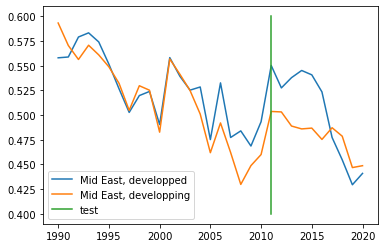

In [24]:
import matplotlib.pyplot as plt

# plot lines
plt.plot(sessions+1945, arrayFrequenciesDvlp[:,5], label = "Mid East, developped")
plt.plot(sessions+1945, arrayFrequenciesDvlpng[:,5], label = "Mid East, developping")
plt.plot([2011, 2011], [0.4, 0.6], label = "test")
#plt.plot(sessions+1945, occurenceOfScienceByYear, label = "Science Medecine")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# plot lines
plt.plot(sessions+1945, arrayFrequenciesDvlp[:,1], label = "Science Medecine, developped")
plt.plot(sessions+1945, arrayFrequenciesDvlpng[:,1], label = "Science Medecine, developping")
#plt.plot(sessions+1945, occurenceOfScienceByYear, label = "Science Medecine")
plt.plot([2007, 2007], [0, 0.04], label = "test")
plt.legend()
plt.show()

In [ ]:
import re
sessions = np.arange(45, 76)

occurenceOfMidEastByYear = []
occurenceOfScienceByYear = []
occurenceOfReligionByYear = []
occurencesByYear = []

for session in sessions:
    speeches = []
    year = 1945 + session
    for i in range(len(df_un_merged.loc[year,:]["Speech"])):
        speech = df_un_merged.loc[year,:]["Speech"][i]
        pattern = r'[0-9]'
        # Match all digits in the string and replace them by empty string
        speech = re.sub(pattern, '', speech)
        speech_splitted = speech.split('.') #split by sentences
        speech_cleaned = [re.sub('\W+',' ', element) for element in speech_splitted] #take out special characters
        speech_cleaned = [x for x in speech_cleaned if x] 
        speech_cleaned = [x for x in speech_cleaned if x.strip()] #take out any empty elements
        speeches += speech_cleaned
    #X_speeches = count_vect.transform(speeches)
    predicted_probas_speeches = text_clf.predict_proba(speeches)
    #print("Number of predicted sentences: ", len(predicted_probas_speeches))
    max_row_proba_index = np.argmax(predicted_probas_speeches, axis=1)
    mask_proba = np.any(predicted_probas_speeches>0.55, axis=1) #mask to keep result only
                                                                #if the max proba > 0.65
    filtered_predictions = max_row_proba_index[mask_proba]
    #print("Number of predicted sentences (cleaned): ", len(filtered_predictions))
    """
    nbOccMidEast = (filtered_predictions == 5).sum()
    nbOccScience = (filtered_predictions == 1).sum()
    nbOccReligion = (filtered_predictions == 7).sum()
    occurenceOfScienceByYear.append(nbOccScience)
    occurenceOfMidEastByYear.append(nbOccMidEast)
    occurenceOfReligionByYear.append(nbOccReligion)
    """
    
    nbOccScience = (filtered_predictions == 1).sum()
    occurenceOfScienceByYear.append(nbOccScience)
    occurencesList = [(filtered_predictions == i).sum() for i in range(8)]
    occurencesByYear.append(occurencesList)

arrayOccurences = np.array(occurencesByYear)
    

In [ ]:
occurenceOfMidEastByYear = arrayOccurences[:,5]

In [ ]:
import matplotlib.pyplot as plt

# plot lines
plt.plot(sessions+1945, occurenceOfMidEastByYear, label = "Mid East")
#plt.plot(sessions+1945, occurenceOfScienceByYear, label = "Science Medecine")
plt.plot([2001, 2001], [7000, 3500], label = "twin towers attack")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# plot lines
plt.plot(sessions+1945, occurenceOfScienceByYear, label = "Science Medecine")
#plt.plot(sessions+1945, occurenceOfScienceByYear, label = "Science Medecine")
plt.plot([2019, 2019], [0, 500], label = "corona attack")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# plot lines
plt.plot(sessions+1945, occurenceOfReligionByYear, label = "Religion")
#plt.plot(sessions+1945, occurenceOfScienceByYear, label = "Science Medecine")
plt.plot([2001, 2001], [0, 300], label = "twin towers attack")
plt.legend()
plt.show()

In [ ]:
import re
sessions = np.arange(45, 76)

occurenceOfMidEastByYear = []
occurenceOfScienceByYear = []
occurenceOfReligionByYear = []
for session in sessions:
    speeches = []
    year = 1945 + session
    speech = df_un_merged.loc[year,"USA"]["Speech"]
    pattern = r'[0-9]'
    # Match all digits in the string and replace them by empty string
    speech = re.sub(pattern, '', speech)
    speech_splitted = speech.split('.') #split by sentences
    speech_cleaned = [re.sub('\W+',' ', element) for element in speech_splitted] #take out special characters
    speech_cleaned = [x for x in speech_cleaned if x] 
    speech_cleaned = [x for x in speech_cleaned if x.strip()] #take out any empty elements
    speeches = speeches + speech_cleaned
    #X_speeches = count_vect.transform(speeches)
    predicted_probas_speeches = text_clf.predict_proba(speeches)
    #print("Number of predicted sentences: ", len(predicted_probas_speeches))
    max_row_proba_index = np.argmax(predicted_probas_speeches, axis=1)
    mask_proba = np.any(predicted_probas_speeches>0.40, axis=1) #mask to keep result only
                                                                #if the max proba > 0.65
    filtered_predictions = max_row_proba_index[mask_proba]
    #print("Number of predicted sentences (cleaned): ", len(filtered_predictions))
    nbOccMidEast = (filtered_predictions == 5).sum()
    nbOccScience = (filtered_predictions == 1).sum()
    nbOccReligion = (filtered_predictions == 7).sum()
    occurenceOfScienceByYear.append(nbOccScience)
    occurenceOfMidEastByYear.append(nbOccMidEast)
    occurenceOfReligionByYear.append(nbOccReligion)
    

In [ ]:
import matplotlib.pyplot as plt

# plot lines
plt.plot(sessions+1945, occurenceOfMidEastByYear, label = "Mid East")
#plt.plot(sessions+1945, occurenceOfScienceByYear, label = "Science Medecine")
plt.plot([2001, 2001], [0, 100], label = "twin towers attack")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# plot lines
plt.plot(sessions+1945, occurenceOfScienceByYear, label = "Science Medecine")
#plt.plot(sessions+1945, occurenceOfScienceByYear, label = "Science Medecine")
plt.plot([2019, 2019], [0, 15], label = "corona attack")
plt.legend()
plt.show()